This notebook is for visualizing each step of the CMMN process so that we can identify the intermediate representations of the whole thing before integrating into our setup.

For now, I will eschew the class based formulation that the original authors provided and just implement everything iteratively, as Dr. B suggested.

Also, this is now a branch of the ICWaves repo so that we can minimize any potential mistakes from separating things into a different package for now.

Here are the main steps for translating cue -> emotion:

1. Load in all source and target data. Emotion has 35 subj.s at 256 hz, cue has 12 subj.s at 500 hz. Load the resampled cue. Since this notebook is for visualization, for now do with a handful of subjects and then visualize with the full list.
2. Calculate the normed barycenter of the source data (emotion). Viz.
3. For each subject, calculate the filter to transform it to this barycenter. Viz.
4. Convolve, visualize before and after of cue.
5. Subj - subj filter calculating, mapping, and visualization as well.

In [11]:
# imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import butter, sosfilt, welch, freqz, sosfreqz
from typing import List, Tuple

In [12]:
# uncomment to viz whole thing
# emotion_subj_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] # note subj. 22 is missing
# cue_subj_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# comment out to do more than a few. just a handful for testing the notebook
emotion_subj_list = ['01', '02', '03', '04']
frolich_subj_list = ['01', '02', '03', '04']

In [13]:
# viz functions
def psd(data, fs=256, nperseg=256):
    """
    Compute the Power Spectral Density (PSD) of the given data.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject
    - fs: sampling frequency (default: 256 Hz)
    - nperseg: length of each segment for Welch's method (default: 256)

    Returns:
    - f: array of sample frequencies (x-axis)
    - Pxx: power spectral density of the data (y-axis)
    """

    f, Pxx = welch(data, fs=fs, nperseg=nperseg)
    return f, Pxx

# Define a function to plot PSD
def plot_psd(data, fs=256, nperseg=256, psds=None, title='PSD'):
    """
    Plot the Power Spectral Density (PSD) of the given data.

    Note: right now this is straight averaging, not the barycenter norming I do later.
    If I want to do the norming, apply that first and then this will not average for me.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject
    - fs: sampling frequency (default: 256 Hz)
    - nperseg: length of each segment for Welch's method (default: 256)
    """
    plt.figure(figsize=(12, 8))

    for i, subj_data in enumerate(data):
        # If subj_data is multi-dimensional, average across the channels

        """
        Note, the below two are different because in the first I average the channels before taking the PSD,
        and in the second I average the channels after taking the PSD.

        Maybe should ask this to Dr. B and Carlos. Which is better since they do seem to result in some differences

        In the rest, when calculating the barycenter and computing the filter, I average AFTER computing the PSD. Follow that convention.

        Clean below later, but keep it as is for now to ask Dr. B and Carlos about it in the meeting later.
        """
        if psds is None:
            # If subj_data is multi-dimensional, average across the channels
            if subj_data.ndim > 1:
                subj_data = np.mean(subj_data, axis=0)
            f, Pxx = psd(subj_data, fs=fs, nperseg=nperseg)

            plt.plot(f, 10 * np.log10(Pxx), label=f'Subject {i+1}')
        else:
            viz_psds = [np.zeros_like(psd) for psd in psds]
            if psds[i].ndim > 1:
                viz_psds[i] = np.mean(psds[i], axis=0)

            f = np.linspace(0, 128, 129)

            plt.plot(f, 10 * np.log10(viz_psds[i]), label=f'Subject {i+1}')


    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title(title)
    plt.legend()
    plt.show()


Structure the data as in the following template:

- data
- - emotion_256
- - - raw_data_and_IC_labels
- - - - subj-01.mat
- - - - ...
- - - - psds
- - - - - subj-01_psds.npz
- - frolich_256
- - - frolich_extract_256_hz
- - - - frolich_extract_01_256_hz.mat
- - - - ...
- - - - psds
- - - - - frolich_extract_01_256_hz_psds.npz

I have this data stored on Caviness under my own repositories / directories. Carlos you should also have access, ping me on Slack otherwise and I will guide you to it.

In [14]:
# load in the data
make_psds = False # change to True if running notebook for the first time. Note: this considerably lenghtens runtime
emotion_filepath = Path('../data/emotion_256/raw_data_and_IC_labels')
frolich_filepath = Path('../data/frolich_256/frolich_extract_256_hz')

# quickly calculate and store the psds here before moving on

# create psds directory
if make_psds:
    (emotion_filepath / 'psds').mkdir(parents=True, exist_ok=True)
    (frolich_filepath / 'psds').mkdir(parents=True, exist_ok=True)

emotion_data = []
for subj in emotion_subj_list:
    emotion_data.append(loadmat(emotion_filepath / f'subj-{subj}.mat')['data'])

if make_psds:
    for i, subj in enumerate(emotion_data):
        f, Pxx = psd(subj)
        np.savez(emotion_filepath / 'psds' / f'subj-{emotion_subj_list[i]}_psds', Pxx)

emotion_data_psds_raw = []
# # if a subdir to psds exists, load those so don't need to calculate here each time
if (emotion_filepath / 'psds').exists():
    for subj in emotion_subj_list:
        emotion_data_psds_raw.append(np.load(emotion_filepath / 'psds' / f'subj-{subj}_psds.npz')['arr_0'])


frolich_data = []
for subj in frolich_subj_list:
    frolich_data.append(loadmat(frolich_filepath / f'frolich_extract_{subj}_256_hz.mat')['X'])

if make_psds:
    for i, subj in enumerate(frolich_data):
        f, Pxx = psd(subj)
        np.savez(frolich_filepath / 'psds' / f'frolich_extract_{frolich_subj_list[i]}_256_hz_psds', Pxx)

frolich_data_psds_raw = []
# if a subdir to psds exists, load those so don't need to calculate here each time
if (frolich_filepath / 'psds').exists():
    for subj in frolich_subj_list:
        frolich_data_psds_raw.append(np.load(frolich_filepath / 'psds' / f'frolich_extract_{subj}_256_hz_psds.npz')['arr_0'])

![title](notebook_figs/cmmn%20wasserstein%20barycenter%20form%20cropped.png)

Here is the equation from the CMMN paper for barycenter matching. Note the hadamard square and square root. Also note that this is over subjects, not a method for averaging the channels.

Equation 6 in the CMMN paper, page 14. For a full derivation, the equation is also in Appendix A, page 14.

In [15]:
# barycenter comp functions
def compute_normed_barycenter(data, psds=None):
    """
    Compute the normed barycenter of the given data.

    I normalize by each subj's sum, as recommended by Dr. B on slack. -- Note, now commented out. Go with original CMMN instead

    data: list of numpy arrays, each containing EEG data for a subject. Each array has shape (n_channels, n_samples).
        Note: these should all be 256 hz, which emotion is natively and cue has been resampled to.
    psds: list of numpy arrays, each containing the PSD of the data for a subject. Each array has shape (n_channels, n_freqs).
    """

    # normalized_psds = []
    # if psds is None:
    #     psds = []
    # for i, subj in enumerate(data):
    #     if psds is None:
    #         f, Pxx = psd(subj)
    #         psds.append(Pxx)
    #         normalized_psds.append(Pxx / np.sum(Pxx))
    #     else:
    #         normalized_psds.append(psds[i] / np.sum(psds[i]))
    #
    # # now average all together
    # per_subj_avgs = []
    # for subj in normalized_psds:
    #     avg = np.mean(subj, axis=0)
    #     per_subj_avgs.append(np.mean(subj, axis=0)) # necessary due to inhomogenous dimensions
    #
    # barycenter = np.mean(per_subj_avgs, axis=0)

    # average per subj psds
    per_subj_avgs = []
    for subj in psds:
        avg = np.mean(subj, axis=0)
        per_subj_avgs.append(avg)

    hadamard_square_root = []
    for subj in per_subj_avgs:
        hadamard_square_root.append(np.sqrt(subj))

    averaged = np.zeros(hadamard_square_root[0].shape)
    for subj in hadamard_square_root:
        averaged += subj

    averaged /= len(hadamard_square_root)

    barycenter = np.square(averaged) # elementwise square

    return barycenter

def plot_barycenter(barycenter):
    """
    Plot the normed barycenter of the given data.

    Parameters:
    - barycenter: numpy array containing the normed barycenter of the data
    """
    plt.figure(figsize=(12, 8))
    f = np.linspace(0, 128, 129)
    plt.plot(f, 10 * np.log10(barycenter))

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title('Normed Barycenter')
    plt.show()

In [16]:
# Computing the mappings
def compute_filter(data, barycenter, psds=None):
    """
    Compute the filter to transform the given data to the barycenter.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject in the target data (cue / frolich here)
    - barycenter: numpy array containing the normed barycenter of the data

    Returns:
    - freq_filter: numpy array containing the filter in the frequency domain
    - time_filter: numpy array containing the filter in the time domain
    """

    # The filter in the frequency domain is barycenter / sqrt of each target subj's PSD
    # Remember, this is not yet subj. to subj. matching. Each subj. is transformed with the same filter. See CMMN paper for details.

    # first get target subj per-subj average to not deal with each channel individually
    # calculate psds for each subj
    if psds is None:
        psds = []
        for subj in data:
            f, Pxx = psd(subj)
            psds.append(Pxx)


    avg_psds_per_subj = [
        np.mean(subj, axis=0) for subj in psds
    ]

    freq_filter_per_subj_explicit = []
    for avg_psd_per_subj in avg_psds_per_subj:
        freq_filter = np.sqrt(barycenter) / np.sqrt(avg_psd_per_subj)
        freq_filter_per_subj_explicit.append(freq_filter)

    time_filter_per_subj_explicit = []
    for subj in freq_filter_per_subj_explicit:
        time_filter = np.fft.ifft(subj)
        time_filter_per_subj_explicit.append(time_filter)

    return freq_filter_per_subj_explicit, time_filter_per_subj_explicit

def plot_freq_filter(freq_filter, fs=256):
    """
    Plot the filter in the frequency domain.

    Parameters:
    - freq_filter: numpy array containing the filter in the frequency domain
    - fs: sampling frequency (default: 256 Hz)

    """

    plt.figure(figsize=(12, 8))
    f = np.linspace(0, fs/2, freq_filter[0].shape[-1])
    for i, subj in enumerate(freq_filter):
        plt.plot(f, 10 * np.log10(np.abs(subj.T)), label=f'Subject {i+1}')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Filter (dB)')
    plt.title('Frequency Filters')
    plt.legend()
    plt.show()

def plot_time_filter(time_filter, fs=256):
    """
    Plot the filter in the time domain.

    Parameters:
    - time_filter: numpy array containing the filter in the time domain
    - fs: sampling frequency (default: 256 Hz)
    """

    plt.figure(figsize=(12, 8))
    t = np.arange(len(time_filter[0])) / fs
    for i, subj in enumerate(time_filter):
        plt.plot(t, np.real(subj), label=f'Subject {i+1}')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Time Domain Filter')
    plt.legend()
    plt.show()

Adding the subj -> subj matching below. This will not use the barycenter calculation from the original paper. Here we instead just take the average PSD of each subject, and then find the closest matching subj in the source domain. Then, compute individual filters for that subject and match appropriately.

Later, this will be wrapped up into a class obj. with more careful tracking.

What is the distance metric of choice? Dr. B recommended me to do the square root of the Euclidean distance between PSDs, but I don't remember the rationale behind that. Should ask him.

In [17]:
def subj_subj_matching(source_psds, target_psds) -> List[int]:
    """

    Parameters
    ----------
    source_psds: list of numpy arrays, each containing the PSD of the data for a subject in the source domain. shape (n_channels, n_freqs)
    target_psds: list of numpy arrays, each containing the PSD of the data for a subject in the target domain. shape (n_channels, n_freqs)

    Returns
    -------
    A list of indices, where the i-th element is the index of the source subject that best matches the i-th target subject.
    Ex: target subj 1 and 2 match to source domain 1, target subj 3 matches to source domain 2: [1, 1, 2]
    """

    # Note the below does not average over channels first, but should still be identical to doing so

    # If source domain has more channels than target domain, I just average over all the psds

    if source_psds[0].shape[0] > target_psds[0].shape[0]:
        correct_source_psds = [np.mean(subj, axis=0) for subj in source_psds]
    else:
        correct_source_psds = source_psds

    subj_subj_matches = []
    for target_psd in target_psds:
        min_dist = float('inf')
        min_idx = -1
        for i, source_psd in enumerate(correct_source_psds):
            dist = np.sqrt(np.sum((np.sqrt(source_psd) - np.sqrt(target_psd))**2))
            if dist < min_dist:
                min_dist = dist
                min_idx = i
        subj_subj_matches.append(min_idx)

    return subj_subj_matches

def compute_filter_subj_subj(data, subj_subj_matches, psds=None):
    """
    Compute the filter to transform the given data to the barycenter, with subject to subject matching.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject in the target data (cue / frolich here)
    - subj_subj_matches: list of indices, where the i-th element is the index of the source subject that best matches the i-th target subject
    - psds: list of numpy arrays, each containing the PSD of the data for a subject. Each array has shape (n_channels, n_freqs).
        Note that the data and psds are for the TARGET domain, here the frolich / cue data.
    """

    # calculate psds for each subj
    if psds is None:
        psds = []
        for subj in data:
            f, Pxx = psd(subj)
            psds.append(Pxx)

    freq_filter_per_subj_explicit = []
    time_filter_per_subj_explicit = []

    for i, subj in enumerate(data):
        subj_psd = psds[i]
        source_psd = psds[subj_subj_matches[i]]

        freq_filter = np.sqrt(source_psd) / np.sqrt(subj_psd)
        time_filter = np.fft.ifft(freq_filter)

        freq_filter_per_subj_explicit.append(freq_filter)
        time_filter_per_subj_explicit.append(time_filter)

    return freq_filter_per_subj_explicit, time_filter_per_subj_explicit

In [30]:
# Computing the transformed data
def transform_data(data, time_filter):
    """
    Transform the given data using the given filter.

    Parameters:
    - data: list of numpy arrays, each containing EEG data for a subject in the target data
    - time_filter: list containing the filter in the time domain for each subject

    Returns:
    - transformed_data: list of numpy arrays, each containing the transformed EEG data for a subject
    """

    # Do the transformation on a channel basis

    transformed_data = []
    for i, subj in enumerate(data):
        subj_norm = np.zeros(subj.shape)
        num_channels = subj.shape[0]

        for chan in range(num_channels):
            # print(subj[chan].shape)
            # print(time_filter[i].shape)
            subj_norm[chan] = np.convolve(subj[chan], time_filter[i], mode='same')

        transformed_data.append(subj_norm)

    return transformed_data

def transform_data_subj_subj(data, time_filter_subj_subj):
    """
    Transform dat with knowledge that the time filter is a list, with each specific to the individual target domain subject

    Parameters
    ----------
    data
    time_filter_subj_subj

    Returns
    -------

    """

    transformed_data = []
    for i, subj in enumerate(data):
        subj_norm = np.zeros(subj.shape)
        num_channels = subj.shape[0]
        time_filter = time_filter_subj_subj[i]

        for chan in range(num_channels):
            # print(subj[chan].shape)
            # print(time_filter[i].shape)
            subj_norm[chan] = np.convolve(subj[chan], time_filter[i], mode='same')

        transformed_data.append(subj_norm)

    return transformed_data


## Computation and Plotting

Now that all data has been loaded and all functions are instantiated, the below code cells calculate and visualize each step.

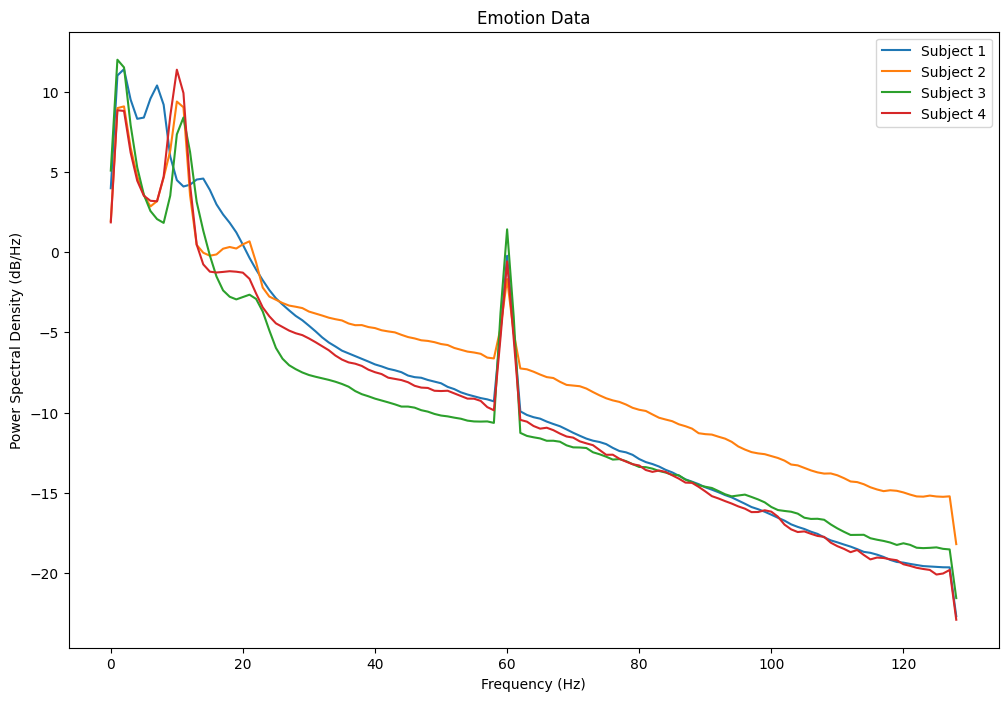

In [19]:
# plot the PSD of the emotion data (averaged over channels)
plot_psd(emotion_data, psds=emotion_data_psds_raw, title='Emotion Data')

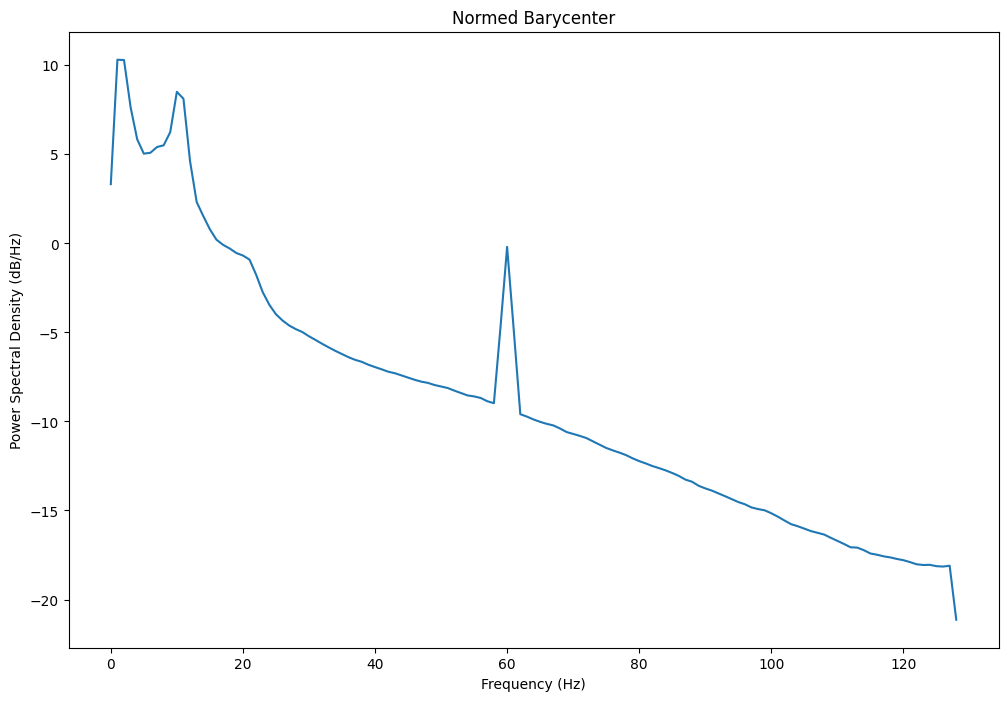

In [20]:
# plot the normed barycenter of the emotion data
normed_emotion_barycenter = compute_normed_barycenter(emotion_data, psds=emotion_data_psds_raw)
plot_barycenter(normed_emotion_barycenter)

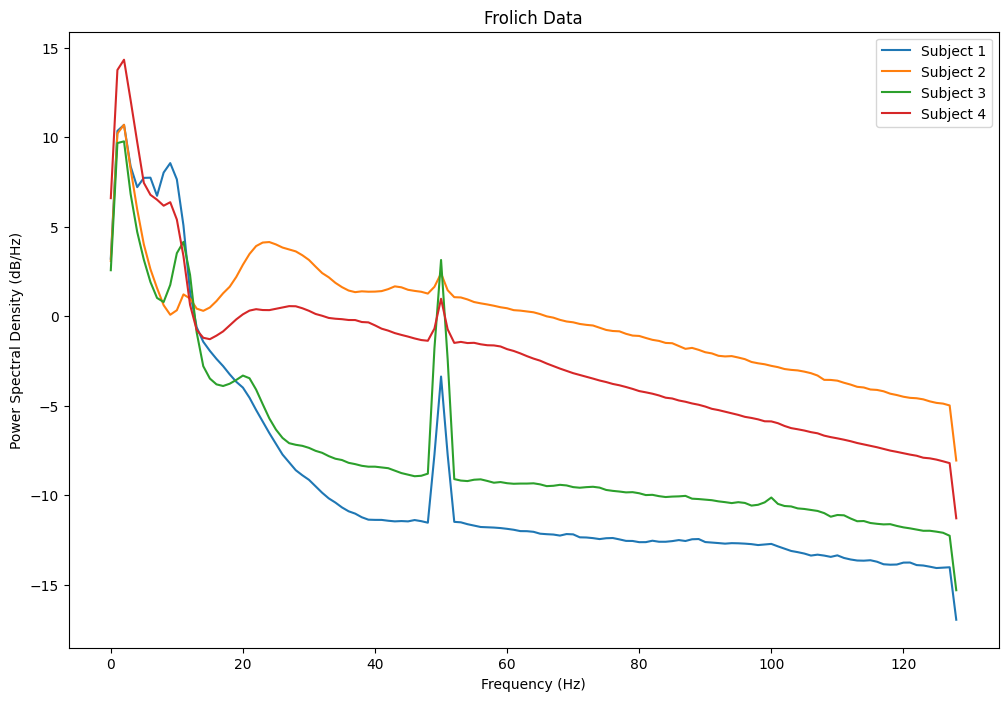

In [21]:
# plot the PSD of the frolich data (averaged over channels)
plot_psd(frolich_data, psds=frolich_data_psds_raw, title='Frolich Data')

Dr. B says zero out 60 hz spike in emotion by doing a notch filter first. Then wouldn't see this big spike in the emotion that the frequency filter needs to account for.

Make sure the pipeline same as Carlos' feature extraction pipeline. Carlos applied a notch filter.

In [22]:
# Plotting filters for cue -> emotion
freq_filter, time_filter = compute_filter(frolich_data, normed_emotion_barycenter)

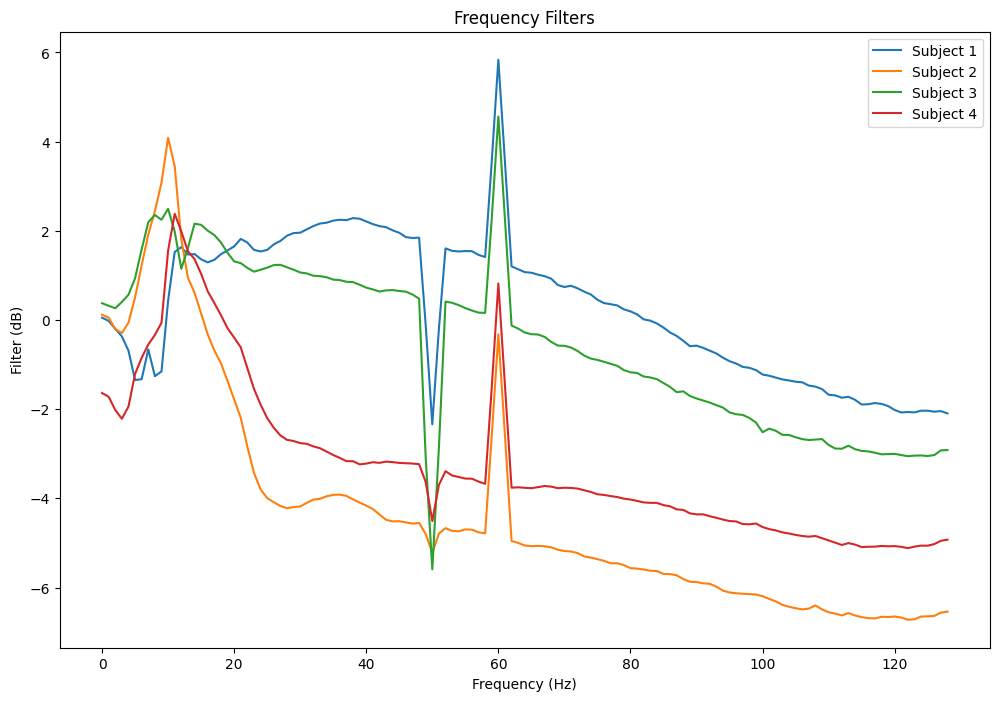

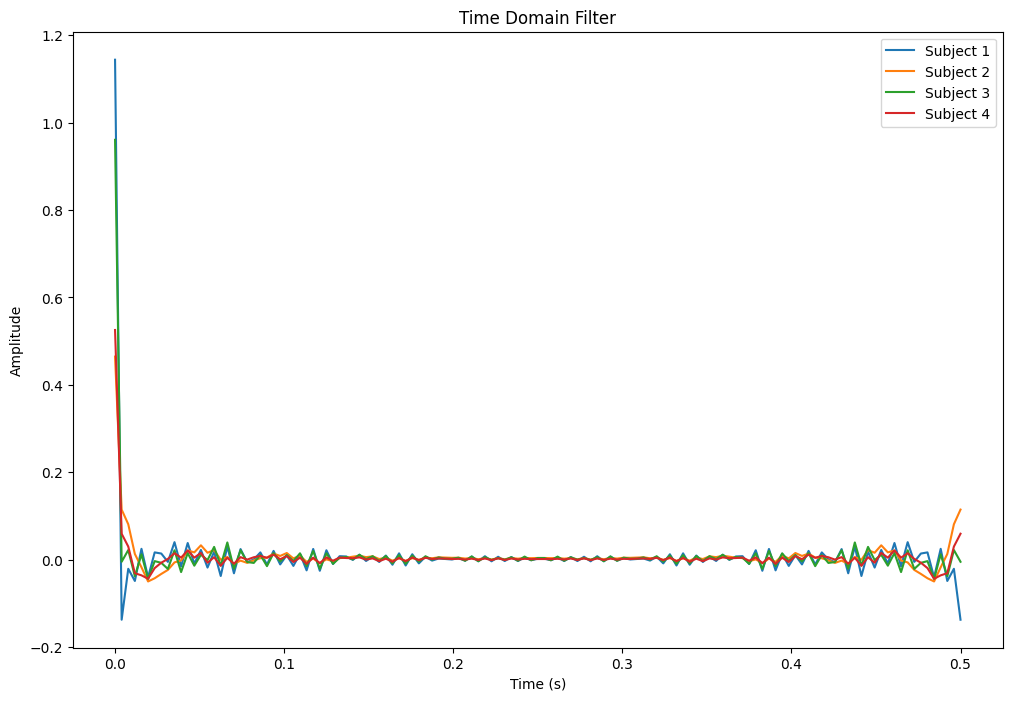

In [23]:
plot_freq_filter(freq_filter)
plot_time_filter(time_filter)

In [24]:
subj_subj_matches = subj_subj_matching(emotion_data_psds_raw, frolich_data_psds_raw)
freq_filter_subj_subj, time_filter_subj_subj = compute_filter_subj_subj(frolich_data, subj_subj_matches, psds=frolich_data_psds_raw)

# print the matches nicely formatted
print(subj_subj_matches)

[3, 1, 1, 1]


In [31]:
transformed_data = transform_data(frolich_data, time_filter)

/tmp/ipykernel_208425/3293124799.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  subj_norm[chan] = np.convolve(subj[chan], time_filter[i], mode='same')


In [32]:
transformed_data_subj_subj = transform_data_subj_subj(frolich_data, time_filter_subj_subj)

/tmp/ipykernel_208425/3293124799.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  subj_norm[chan] = np.convolve(subj[chan], time_filter[i], mode='same')


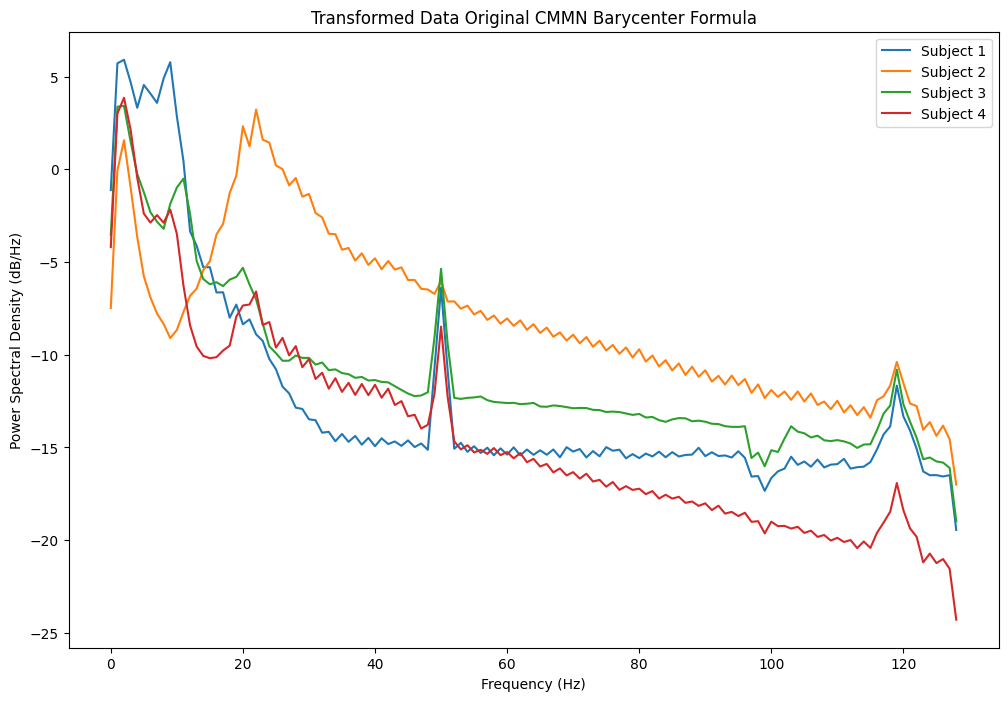

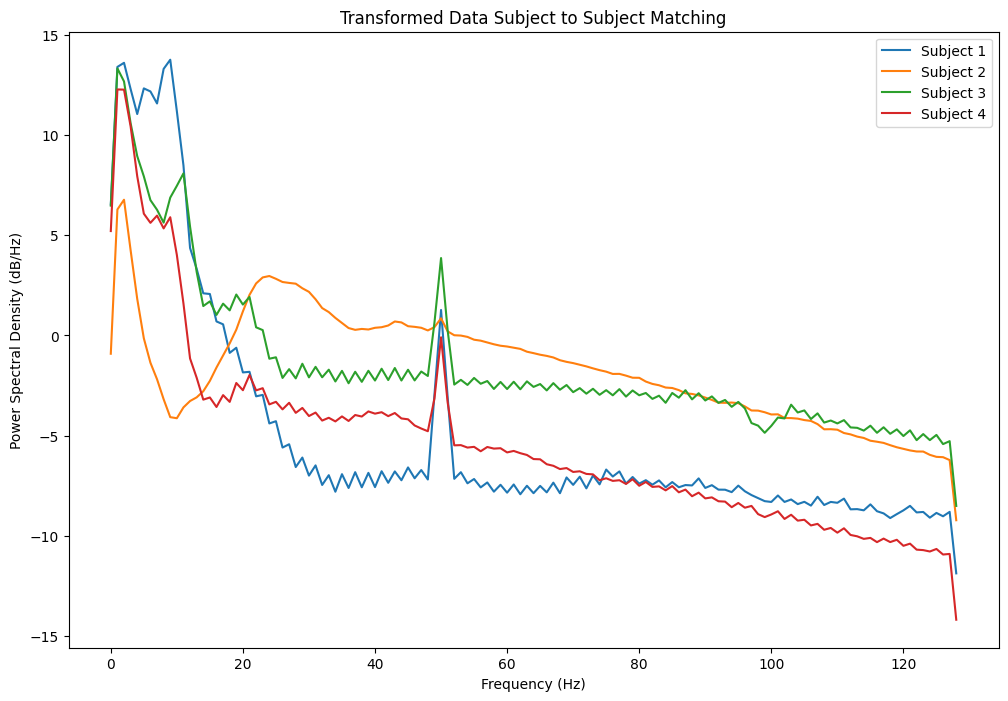

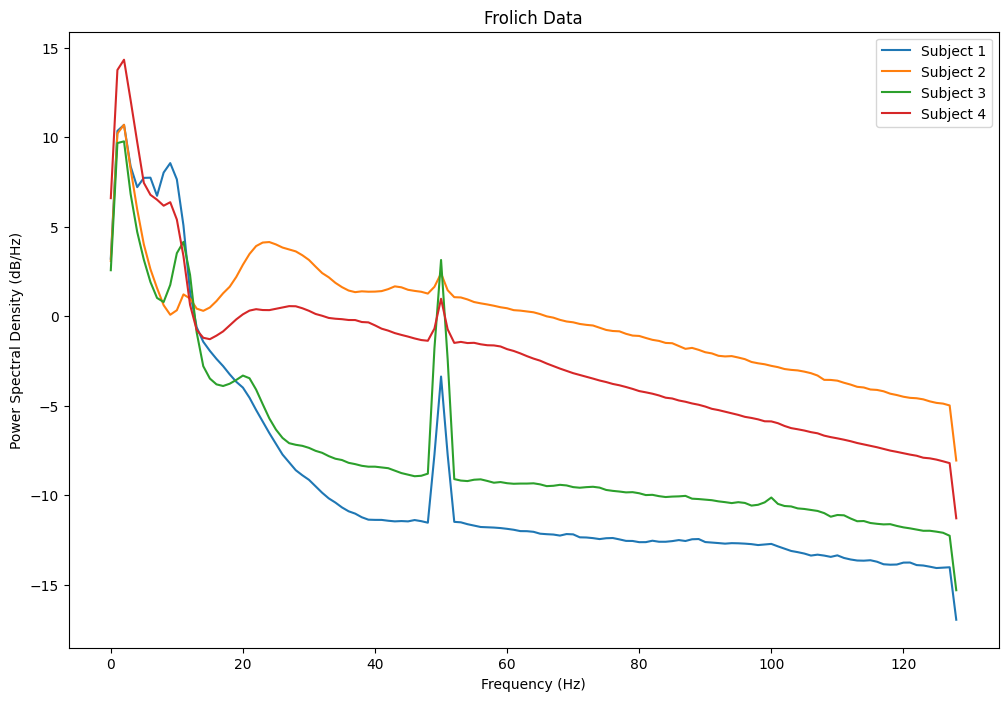

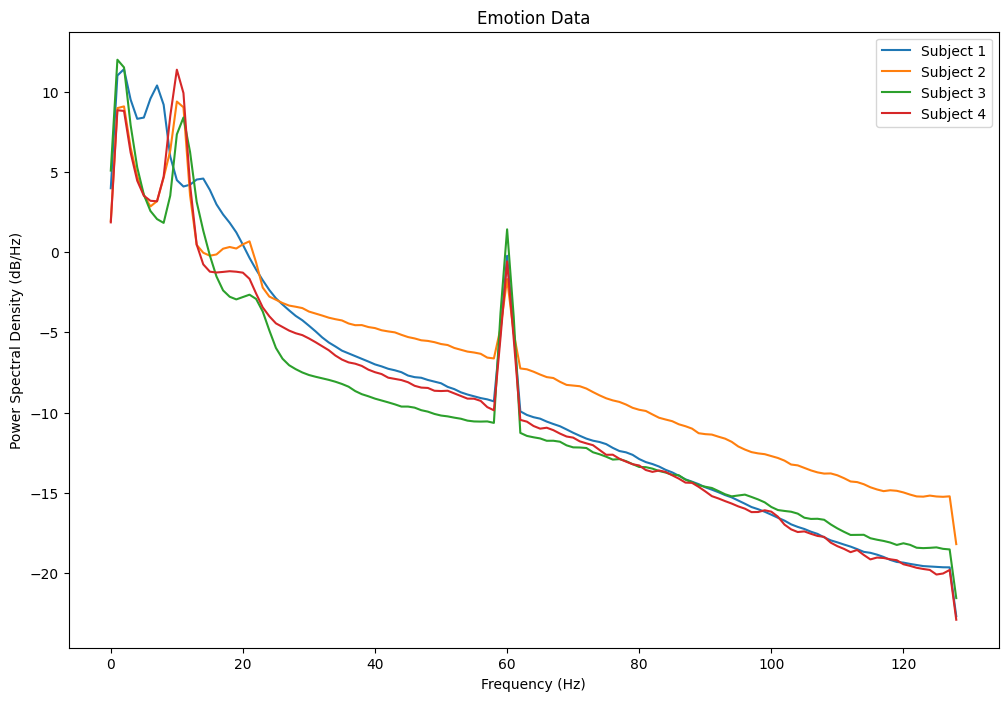

In [29]:
# plot the PSD of the transformed data (averaged over channels)
plot_psd(transformed_data, title='Transformed Data Original CMMN Barycenter Formula')
plot_psd(transformed_data_subj_subj, title='Transformed Data Subject to Subject Matching')
plot_psd(frolich_data, psds=frolich_data_psds_raw, title='Frolich Data')
plot_psd(emotion_data, psds=emotion_data_psds_raw, title='Emotion Data')

TODO from last full meeting with Dr. B & Carlos:
- [x] Eliminate implicit broadcasting, loop over every subject explicitly due to bug prone mismatches
- [x] Store, load, average PSDs properly
- [x] Reference the original paper's barycenter rule, use that instead for now.
- [x] Subj - subj matching and filter calculation

Questions for Dr. B and Carlos
- What is most common? Averaging PSDs before or after taking the PSD? I noticed that they lead to some different results ... see cell above.
- Filters look more reasonable to me, but do not understand why they are jagged and have a spike at the end of them.

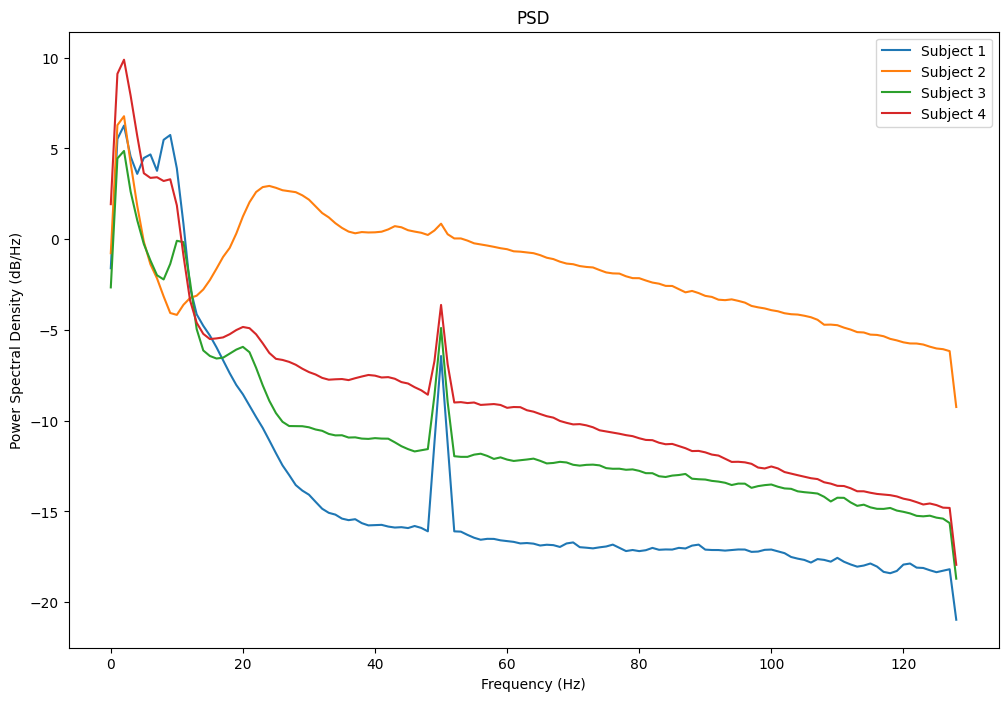

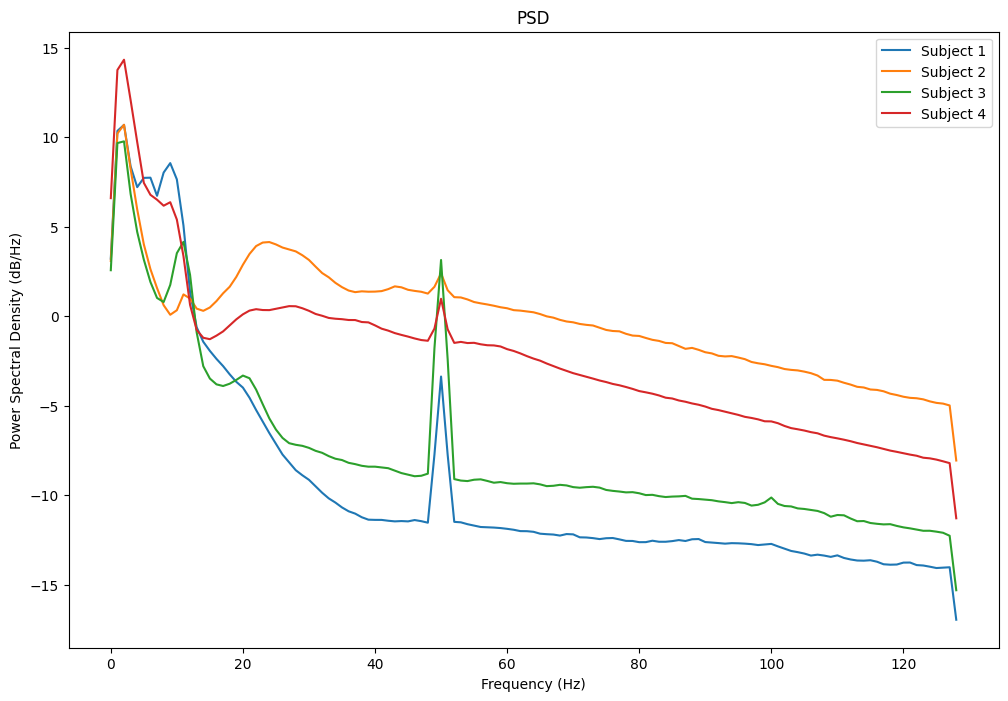

In [33]:
# Difference between averaging channels and then taking PSD vs. taking PSD and then averaging channels, respectively

# average before
plot_psd(frolich_data, psds=None)

# average after
plot_psd(frolich_data, psds=frolich_data_psds_raw)